In [1]:
import tensorflow as tf
import numpy as np
import gym
import datetime
from tqdm import tqdm_notebook
import logging
import random
import itertools
from go_ai import go_utils, rl_utils
import matplotlib.pyplot as plt
import collections
from functools import reduce
import mcts

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Hyperparameters

In [3]:
BOARD_SIZE = 5

In [4]:
ITERATIONS = 256
EPISODES_PER_ITERATION = 8
MAX_STEPS = 2 * BOARD_SIZE**2
BATCH_SIZE = 64

In [5]:
LEARNING_RATE = 1e-2
BETA_1 = 0.9

In [6]:
SAVE_EVERY_ITERATION = True
LOAD_SAVED_MODELS = True
BASELINE_DIR = 'model_baselines/'
LEVEL_PATHS = [None]

In [7]:
EXPLORE_WEIGHT = 0.1
EXPLORE_DECAY = 0.9
MIN_EXPLORE = 0.1
CRITIC_GAMMA = 1/2

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [8]:
go_env = gym.make('gym_go:go-v0', size=BOARD_SIZE, reward_method='heuristic')

# Machine Learning Models

In [9]:
ACTOR_CRITIC_PATH = 'tmp/actor_critic.h5'

In [10]:
actor_critic = rl_utils.make_actor_critic(BOARD_SIZE, 'val_net', 'tanh')

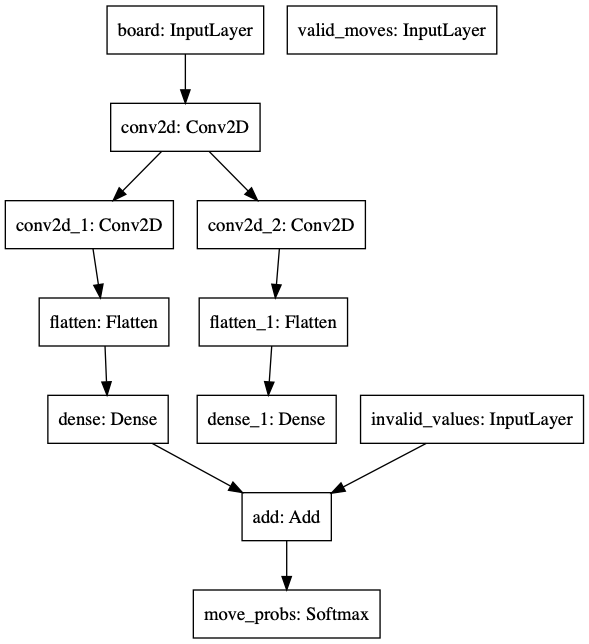

In [11]:
tf.keras.utils.plot_model(actor_critic)

In [12]:
actor_critic.summary()

Model: "actor_critic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 5, 5, 6)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 5, 32)     1760        board[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 5, 2)      578         conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 50)           0           conv2d_1[0][0]                   
_______________________________________________________________________________________

### Initialization of models 

In [13]:
mct_forward = rl_utils.make_mcts_forward(actor_critic)

In [14]:
mem = []
state = go_env.reset()
action = (1,4)
action_1d = BOARD_SIZE * action[0] + action[1]
next_state, reward, done, info = go_env.step(action)
mct = mcts.MCTree(state, mct_forward)
mc_pi, _ = mct.get_action_probs(max_num_searches=25, temp=1)
rl_utils.add_to_replay_mem(mem, state, action_1d, next_state, reward, done, 0, mc_pi)

W0912 20:51:29.781114 4382954944 base_layer.py:1772] Layer conv2d is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



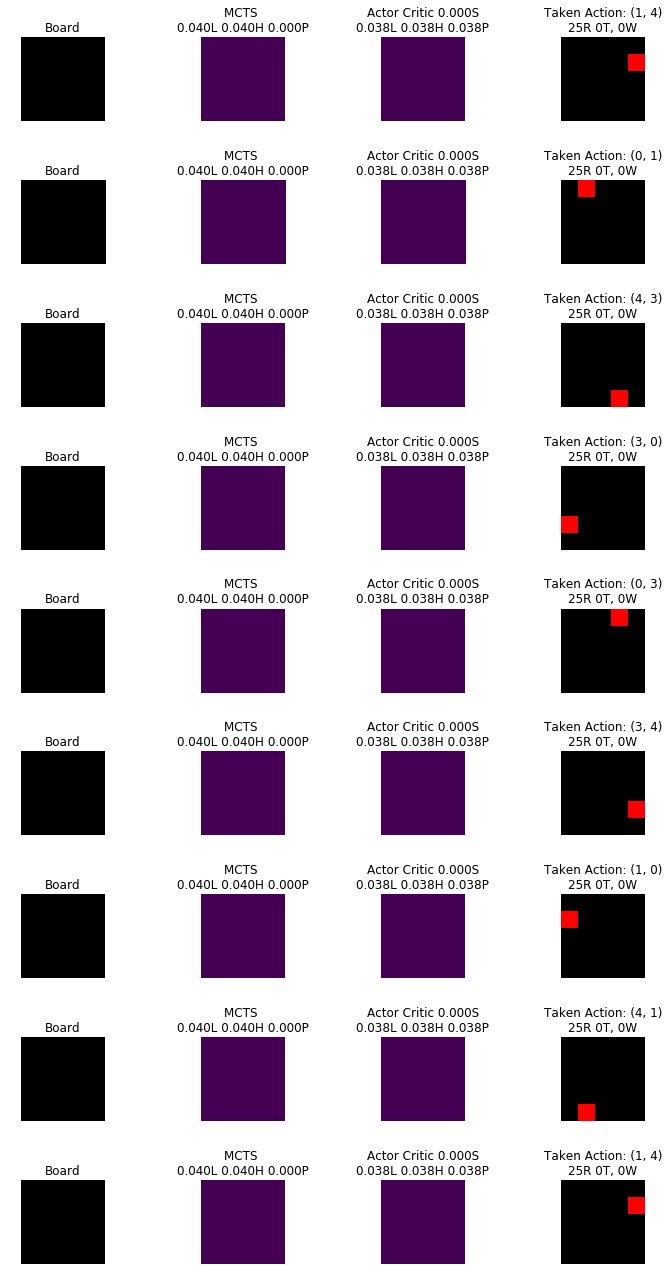

In [15]:
plt.show(rl_utils.sample_heatmaps(actor_critic, mem, num_samples=8))

# Training Setup

### Metrics and Tensorboard

In [16]:
!rm -rf ./logs/

Metrics

In [17]:
metrics = {}
for metric_key in ['val_loss', 'explore_loss', 'overall_loss', 'win_rate', 'num_steps', 'explore_weight', 'move_loss']:
    metrics[metric_key] = tf.keras.metrics.Mean('{}'.format(metric_key), dtype=tf.float32)
metrics['pred_win_acc'] = tf.keras.metrics.Accuracy()

Tensorboard

In [18]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/actor_critic/{}/main'.format(current_time)
summary_writer = tf.summary.create_file_writer(log_dir)    

### Helper Functions

In [ ]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
actor_critic_opt = tf.keras.optimizers.Adam(LEARNING_RATE, BETA_1)

In [ ]:
def update_actor_critic(batched_mem, iteration, metrics):
    """
    Optimizes the actor over the whole replay memory
    """ 
    explore_weight = max(EXPLORE_WEIGHT * (EXPLORE_DECAY**iteration), MIN_EXPLORE)
    for states, actions, next_states, rewards, terminals, wins, mcts_action_probs in tqdm_notebook(batched_mem, 
                                                                                desc='Updating actor_critic', 
                                                                                leave=False):
        batch_size = states.shape[0]
        
        # Actor
        valid_moves = go_utils.get_valid_moves(states)
        
        # Critic
        wins = wins[:,np.newaxis]
        next_move_probs, next_move_vals = rl_utils.forward_pass(next_states, actor_critic, training=True)
        targets = rewards + CRITIC_GAMMA * tf.math.reduce_sum(next_move_probs * next_move_vals, axis=1, keepdims=True)
        with tf.GradientTape() as tape:    
            move_prob_distrs, state_vals = rl_utils.forward_pass(states, actor_critic, training=True)
            
            # Actor
            move_loss = tf.reduce_sum(mcts_action_probs * tf.math.log(move_prob_distrs 
                                                                      + tf.keras.backend.epsilon()), axis=1)
            move_loss = tf.reduce_mean(move_loss)
            
            # Critic
            assert state_vals.shape == wins.shape
            val_loss = tf.reduce_mean((wins - state_vals)**2)
            
            overall_loss = val_loss + move_loss
        
#         metrics['explore_loss'].update_state(explore_loss)
#         metrics['explore_weight'].update_state(explore_weight)
        
        metrics['move_loss'].update_state(move_loss)
        metrics['val_loss'].update_state(val_loss)
        
        metrics['overall_loss'].update_state(overall_loss)
        
        wins_01 = np.copy(wins)
        wins_01[wins_01 < 0] = 0
        metrics['pred_win_acc'].update_state(wins_01, state_vals > 0)
        
        # compute and apply gradients
        gradients = tape.gradient(overall_loss, actor_critic.trainable_variables)
        actor_critic_opt.apply_gradients(zip(gradients, actor_critic.trainable_variables))

# Train

In [ ]:
opponent = tf.keras.models.clone_model(actor_critic)

In [ ]:
if LOAD_SAVED_MODELS:
    actor_critic.save_weights(ACTOR_CRITIC_PATH)
    opponent.save_weights(ACTOR_CRITIC_PATH)
    logging.info("Loaded saved models")

I0912 20:51:32.854259 4382954944 <ipython-input-23-95e71f229ce5>:4] Loaded saved models


In [ ]:
replay_mem = []

In [ ]:
for iteration in tqdm_notebook(range(ITERATIONS), desc='Iteration'):
    # Update other models if appropriate
    if SAVE_EVERY_ITERATION:
        logging.debug("Saving weights...")
        actor_critic.save_weights(ACTOR_CRITIC_PATH)

    # Train
    logging.debug("Playing games")
    episode_pbar = tqdm_notebook(range(EPISODES_PER_ITERATION), desc='Episode {}'.format(iteration), leave=False)
    for episode in episode_pbar:
        num_steps = rl_utils.play_a_game(replay_mem, go_env, policy=actor_critic, max_steps=MAX_STEPS, mc_sims=25)
        metrics['num_steps'].update_state(num_steps)

    # Update the models (also shuffles memory)
    logging.debug("Updating model...")
    random.shuffle(replay_mem)
    np_data = rl_utils.replay_mem_to_numpy(replay_mem)
    batched_np_data = [np.array_split(datum, len(replay_mem) // BATCH_SIZE) for datum in np_data]
    batched_mem = list(zip(*batched_np_data))
    update_actor_critic(batched_mem, iteration, metrics)
    
    # Evaluate against previous model
    win_rate = rl_utils.evaluate(go_env, actor_critic, opponent, MAX_STEPS, num_games=8, mc_sims=25)
    metrics['win_rate'](win_rate)
    
    if win_rate > 0.6:
        actor_critic.save_weights(ACTOR_CRITIC_PATH)
        opponent.load_weights(ACTOR_CRITIC_PATH)
        logging.info("Accepted new model")
    else:
        logging.info("Rejected new model")
    
    # Log results and resets the metrics
    logging.debug("Logging metrics to tensorboard...")
    rl_utils.log_to_tensorboard(summary_writer, metrics, iteration, replay_mem, actor_critic)

    # Reset memory
    replay_mem.clear()

I0912 20:59:51.694476 4382954944 <ipython-input-25-e31bbd8c76fa>:29] Accepted new model


I0912 21:04:09.966234 4382954944 <ipython-input-25-e31bbd8c76fa>:31] Rejected new model


I0912 21:09:39.265692 4382954944 <ipython-input-25-e31bbd8c76fa>:31] Rejected new model


# Evaluate

Evaluate against different levels of opponents

In [ ]:
rl_utils.evaluate(go_env, actor_critic, opponent, LEVEL_PATHS, MAX_STEPS)

Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size=7)
rl_utils.play_against(actor_critic, go_env)